In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.station_network import StationNetworkSimul
import networkx as nx
import random
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from gnn_model import StationFlowGNN
import torch
import torch.optim as optim
from tqdm import tqdm
import pickle
import seaborn as sns

In [4]:
df_stations = pd.read_csv('plan du métro.csv')
df_stations = df_stations[~df_stations['vers Ligne'].isin(['\xa01', '\xa07', '\xa02', '\xa08', '\xa06'])]

df_pos = pd.read_csv("position gps des stations de métro.csv")

#Removing Malsesherbes RER Station
df_pos = df_pos.drop([151])

df_flow = pd.read_csv('passagers.csv')
df_flow['nombre'] = df_flow['nombre'].astype(float)

In [5]:
path_flows = df_flow[['de', 'vers', 'nombre']].to_dict('records')

In [6]:
test_network = StationNetworkSimul(df_stations=df_stations, df_pos=df_pos)

In [23]:
test_network.set_edges_weights()
test_network.set_nodes_traffic(path_flows=path_flows)

In [19]:
for idx, node_data in test_network.network_graph.nodes.data():
    if node_data['traffic'] == 0:
        print(node_data['title'], node_data['group'])

In [32]:
def create_degraded_networks(net_simul : StationNetworkSimul, num_delete, num_degraded, data_dir):
    degraded_graphs = []
    for i in tqdm(range(num_degraded), total=num_degraded):
        new_net, removed_edges = net_simul.get_degraded_network(num_delete=num_delete)
        hash_removed  = hash(tuple(sorted(removed_edges)))
        
        os.makedirs(os.path.join(data_dir, f'delete_{num_delete}'), exist_ok=True)
        degraded_graph_path  = os.path.join(data_dir, f'delete_{num_delete}', f'{hash_removed}.gpickle')
        if os.path.exists(degraded_graph_path):
            # print(f"Getting graph {hash_removed} from precomputed data")
            with open(degraded_graph_path, 'rb') as f:
                new_net = pickle.load(f)
        else:
            # print(f"Creating and saving graph {hash_removed}")
            net_simul.update_degraded_network_nodes_traffic(new_net, removed_edges, df_flow)
            with open(degraded_graph_path, 'wb') as f:
                pickle.dump(new_net, f)
        degraded_graphs.append(new_net)
    return degraded_graphs
        

In [33]:
for i in range(2,11):
    create_degraded_networks(test_network, num_delete=i, num_degraded=100, data_dir="graph_dataset/")

# create_degraded_networks(test_network, num_delete=1, num_degraded=200, data_dir="graph_dataset/")

100%|██████████| 100/100 [1:06:24<00:00, 39.84s/it]


In [22]:
def pick_random_files(folder_path, num_files):
    all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if num_files > len(all_files):
        raise ValueError("The folder doesn't contain enough files to sample the requested number.")
    random_files = random.sample(all_files, num_files)
    return random_files

In [23]:
path = os.path.join("graph_dataset/", 'delete_1')
random_files = pick_random_files(path, 2)

In [25]:
with open(os.path.join("graph_dataset/", 'delete_1', random_files[0]), 'rb') as f:
    G = pickle.load(f)

In [10]:
def MAPE_loss(y_pred, y_true, mean=True):
    """
    Compute the Mean Absolute Percentage Error for the model predictions.

    Inputs:
        - y_pred : model predictions
        - y_true : true values
    
    Return:
        MAPE : Mean Absolute Percentage Error
    """

    APE = torch.abs(y_pred - y_true)/torch.abs(y_true)
    if mean:
        APE = torch.mean(APE)
    return APE

## GCN Models

### Using node position as input

In [22]:
data_dir = "graph_dataset/"

train_degraded_graphs = []
dev_degraded_graphs = []
test_degraded_graphs = []

for i in range(1,11):
    folder_path = os.path.join(data_dir, f'delete_{i}')
    all_files = [file_path for file_path in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file_path))]
    degraded_graphs = []

    print(f"Number of graphs where {i} edges were deleted: {len(all_files)}")
    for file_path in all_files:
        with open(os.path.join(folder_path, file_path), 'rb') as f:
            new_net = pickle.load(f)
        
        tensor_positions = torch.tensor([[node['x'], node['y']] for _, node in sorted(new_net.nodes.data())], dtype=torch.float)
        tensor_edges = torch.tensor([
            [edge[0] for edge in new_net.edges],
            [edge[1] for edge in new_net.edges]
            ], dtype=torch.long)
        tensor_traffic = torch.tensor([node['traffic'] for _, node in sorted(new_net.nodes.data())], dtype=torch.float)
        data_graph = Data(x=tensor_positions, edge_index=tensor_edges, y=tensor_traffic)
        degraded_graphs.append(data_graph)

    train_split_idx = int(0.9*len(all_files))
    dev_split_idx = int(0.1*train_split_idx)

    dev_degraded_graphs.extend(degraded_graphs[:dev_split_idx])
    train_degraded_graphs.extend(degraded_graphs[dev_split_idx:train_split_idx])
    test_degraded_graphs.extend(degraded_graphs[train_split_idx:])

Number of graphs where 1 edges were deleted: 142
Number of graphs where 2 edges were deleted: 100
Number of graphs where 3 edges were deleted: 100
Number of graphs where 4 edges were deleted: 100
Number of graphs where 5 edges were deleted: 100
Number of graphs where 6 edges were deleted: 100
Number of graphs where 7 edges were deleted: 100
Number of graphs where 8 edges were deleted: 100
Number of graphs where 9 edges were deleted: 100
Number of graphs where 10 edges were deleted: 100


In [23]:
train_loader = DataLoader(train_degraded_graphs, shuffle=True)
dev_loader = DataLoader(dev_degraded_graphs, shuffle=True)
test_loader = DataLoader(test_degraded_graphs, shuffle=True)

In [24]:
input_dim = train_loader.dataset[0].x.shape[1]
output_dim = 1

nodes_gnn_model = StationFlowGNN(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
)

lr = 0.001
optimizer = optim.Adam(nodes_gnn_model.parameters(), lr=lr)
criterion = torch.nn.L1Loss()

epochs = 20

for epoch in range(epochs):
    nodes_gnn_model.train()
    train_loss = []
    for data in train_loader:
        nodes_gnn_model.train()
        optimizer.zero_grad()
        x, edge_index = data.x, data.edge_index
        output = nodes_gnn_model(x, edge_index)
        loss = criterion(output.squeeze(), data.y)
        # loss = MAPE_loss(output.squeeze(), data.y)s
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    # if epoch%10 == 0:
    dev_loss = []
    nodes_gnn_model.eval()
    for data in dev_loader:
        x, edge_index = data.x, data.edge_index
        output = nodes_gnn_model(x, edge_index)
        loss = MAPE_loss(output.squeeze(), data.y)
        dev_loss.append(loss.item())
    print(f'Epoch {epoch}, Train Loss: {np.mean(train_loss)}, Dev. MAPE: {np.mean(dev_loss)}')


Epoch 0, Train Loss: 12488.577352080865, Dev. MAPE: 0.7889250472027768
Epoch 1, Train Loss: 10618.366654093232, Dev. MAPE: 0.7854446858488103
Epoch 2, Train Loss: 10618.309524029917, Dev. MAPE: 0.7868516893797023
Epoch 3, Train Loss: 10618.490623148697, Dev. MAPE: 0.7736352739795562
Epoch 4, Train Loss: 10618.482228645216, Dev. MAPE: 0.7830386174622402
Epoch 5, Train Loss: 10618.248172995038, Dev. MAPE: 0.7868090150176837
Epoch 6, Train Loss: 10618.204439425355, Dev. MAPE: 0.77486059101679
Epoch 7, Train Loss: 10618.194965380628, Dev. MAPE: 0.7938930655038485
Epoch 8, Train Loss: 10617.899259015847, Dev. MAPE: 0.7818816611843724
Epoch 9, Train Loss: 10617.327430761256, Dev. MAPE: 0.785193407407371
Epoch 10, Train Loss: 10617.199617937278, Dev. MAPE: 0.800647549731757
Epoch 11, Train Loss: 10617.327865817535, Dev. MAPE: 0.7793029373691928
Epoch 12, Train Loss: 10616.964382081234, Dev. MAPE: 0.7807215215057455
Epoch 13, Train Loss: 10616.724657971712, Dev. MAPE: 0.772619774264674
Epoch 1

In [25]:
test_mae = []
test_mape = []
nodes_gnn_model.eval()
for data in test_loader:
    x, edge_index = data.x, data.edge_index
    output = nodes_gnn_model(x, edge_index)
    test = set(output.squeeze().tolist())
    print(max(test), min(test))
    MAE = criterion(output.squeeze(), data.y)
    MAPE = MAPE_loss(output.squeeze(), data.y)
    test_mae.append(MAE.item())
    test_mape.append(MAPE.item())
print(f'Test MAE: {np.mean(test_mae)}; Test MAPE: {np.mean(test_mape)}')

21421.865234375 14013.1904296875
21445.359375 13989.634765625
22198.59765625 12550.9375
21445.359375 12335.6123046875
21722.5703125 13993.9794921875
21621.41796875 14092.6513671875
21731.662109375 14092.6513671875
21445.359375 13984.23046875
21478.947265625 14049.0732421875
21447.888671875 13984.23046875
21566.068359375 13989.634765625
21600.154296875 14014.62890625
21445.359375 13984.23046875
21447.888671875 13984.23046875
21638.5703125 14092.6513671875
22231.373046875 13501.3603515625
21607.38671875 14092.6513671875
21724.18359375 11570.0263671875
21607.140625 13984.23046875
21688.05859375 13984.23046875
22014.185546875 13668.7724609375
21575.44921875 14053.60546875
21447.888671875 14092.6513671875
21638.5 13801.5771484375
21642.23828125 14092.6513671875
21445.359375 13987.462890625
21750.453125 13668.779296875
21445.359375 13984.23046875
21462.78515625 14055.1455078125
22471.60546875 13678.9541015625
21719.33984375 13984.23046875
21481.833984375 13984.23046875
21634.83203125 13984.2

(392,)
(392,)


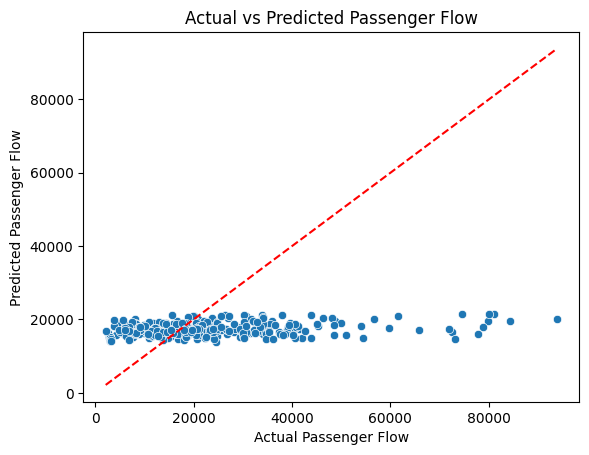

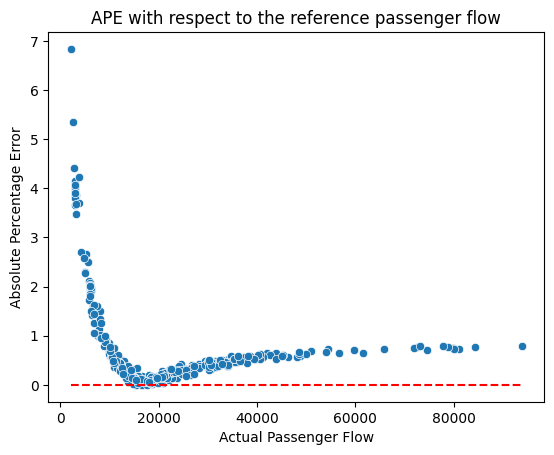

In [26]:
# test_data = random.choice(test_loader.dataset)
test_data = test_loader.dataset[0]
x, edge_index = test_data.x, test_data.edge_index
output = nodes_gnn_model(x, edge_index)

ape_predictions = MAPE_loss(y_true=test_data.y, y_pred=output.squeeze(), mean=False)
ape_predictions = ape_predictions.detach()

actual_flows = test_data.y.numpy()
predicted_flows = output.detach().squeeze(1).numpy()

print(actual_flows.shape)
print(predicted_flows.shape)

plt.figure(1)
sns.scatterplot(x=actual_flows, y=predicted_flows)
plt.plot([min(actual_flows), max(actual_flows)],
         [min(actual_flows), max(actual_flows)],
         color='red', linestyle='--')  # Perfect match line
plt.xlabel("Actual Passenger Flow")
plt.ylabel("Predicted Passenger Flow")
plt.title("Actual vs Predicted Passenger Flow")

plt.figure(2)
sns.scatterplot(x=actual_flows, y=ape_predictions)
plt.plot([min(actual_flows), max(actual_flows)],
         [0, 0],
         color='red', linestyle='--')  # Perfect match line
plt.xlabel("Actual Passenger Flow")
plt.ylabel("Absolute Percentage Error")
plt.title("APE with respect to the reference passenger flow")

plt.show()


### Using node embedding (initialized + updated during training) as input

#### Unweighted edges

In [30]:
data_dir = "graph_dataset/"

train_degraded_graphs = []
dev_degraded_graphs = []
test_degraded_graphs = []

for i in range(1,11):
    folder_path = os.path.join(data_dir, f'delete_{i}')
    all_files = [file_path for file_path in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file_path))]
    degraded_graphs = []

    print(f"Number of graphs where {i} edges were deleted: {len(all_files)}")
    for file_path in all_files:
        with open(os.path.join(folder_path, file_path), 'rb') as f:
            new_net = pickle.load(f)
        
        node_idx = torch.tensor([i for i in sorted(new_net.nodes)], dtype=torch.int)
        tensor_edges = torch.tensor([
            [edge[0] for edge in new_net.edges],
            [edge[1] for edge in new_net.edges]
            ], dtype=torch.long)
        tensor_traffic = torch.tensor([node['traffic'] for _, node in sorted(new_net.nodes.data())], dtype=torch.float)
        data_graph = Data(x=node_idx, edge_index=tensor_edges, y=tensor_traffic)
        degraded_graphs.append(data_graph)

    train_split_idx = int(0.9*len(all_files))
    dev_split_idx = int(0.1*train_split_idx)

    dev_degraded_graphs.extend(degraded_graphs[:dev_split_idx])
    train_degraded_graphs.extend(degraded_graphs[dev_split_idx:train_split_idx])
    test_degraded_graphs.extend(degraded_graphs[train_split_idx:])

Number of graphs where 1 edges were deleted: 142
Number of graphs where 2 edges were deleted: 100
Number of graphs where 3 edges were deleted: 100
Number of graphs where 4 edges were deleted: 100
Number of graphs where 5 edges were deleted: 100
Number of graphs where 6 edges were deleted: 100
Number of graphs where 7 edges were deleted: 100
Number of graphs where 8 edges were deleted: 100
Number of graphs where 9 edges were deleted: 100
Number of graphs where 10 edges were deleted: 100


In [31]:
train_loader = DataLoader(train_degraded_graphs, shuffle=True)
dev_loader = DataLoader(dev_degraded_graphs, shuffle=True)
test_loader = DataLoader(test_degraded_graphs, shuffle=True)

In [32]:
input_dim = 100
output_dim = 1

nodes_gnn_model = StationFlowGNN(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
    use_embeddings=True
)

lr = 0.001
optimizer = optim.Adam(nodes_gnn_model.parameters(), lr=lr)
criterion = torch.nn.L1Loss()

epochs = 20

for epoch in range(epochs):
    nodes_gnn_model.train()
    train_loss = []
    for data in train_loader:
        nodes_gnn_model.train()
        optimizer.zero_grad()
        x, edge_index = data.x, data.edge_index
        output = nodes_gnn_model(x, edge_index)
        loss = criterion(output.squeeze(), data.y)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    dev_loss = []
    nodes_gnn_model.eval()
    for data in dev_loader:
        x, edge_index = data.x, data.edge_index
        output = nodes_gnn_model(x, edge_index)
        loss = MAPE_loss(output.squeeze(), data.y)
        dev_loss.append(loss.item())
    print(f'Epoch {epoch}, Train Loss: {np.mean(train_loss)}, Dev. MAPE: {np.mean(dev_loss)}')


TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
test_mae = []
test_mape = []
nodes_gnn_model.eval()
for data in test_loader:
    x, edge_index = data.x, data.edge_index
    output = nodes_gnn_model(x, edge_index)
    test = set(output.squeeze().tolist())
    print(max(test), min(test))
    MAE = criterion(output.squeeze(), data.y)
    MAPE = MAPE_loss(output.squeeze(), data.y)
    test_mae.append(MAE.item())
    test_mape.append(MAPE.item())
print(f'Test MAE: {np.mean(test_mae)}; Test MAPE: {np.mean(test_mape)}')

75121.59375 2253.9189453125
74458.953125 2184.698974609375
75624.6015625 2184.698974609375
72031.640625 2194.768310546875
74978.75 2184.698974609375
74969.625 2184.698974609375
74458.953125 2184.698974609375
95258.1875 2253.9189453125
75232.7734375 2184.698974609375
74458.953125 2265.851318359375
74458.953125 2184.698974609375
74326.84375 2184.698974609375
74448.8984375 1988.58203125
68450.5 2184.698974609375
74459.671875 2253.9189453125
74458.953125 2184.698974609375
74973.640625 2419.539306640625
74458.953125 2184.698974609375
74600.953125 2184.698974609375
68597.6484375 2184.698974609375
74459.671875 2184.698974609375
73894.203125 2184.698974609375
83497.5625 2184.698974609375
75492.71875 2184.698974609375
74802.6328125 2184.698974609375
89478.953125 2184.698974609375
74458.953125 2184.698974609375
93530.125 2184.698974609375
74452.5 2184.698974609375
75766.734375 2184.698974609375
74543.125 1938.74462890625
74458.953125 2184.698974609375
84506.8984375 2184.698974609375
74600.953125

(392,)
(392,)


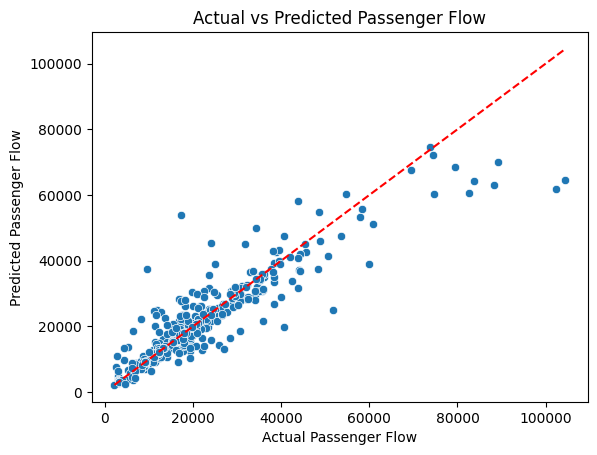

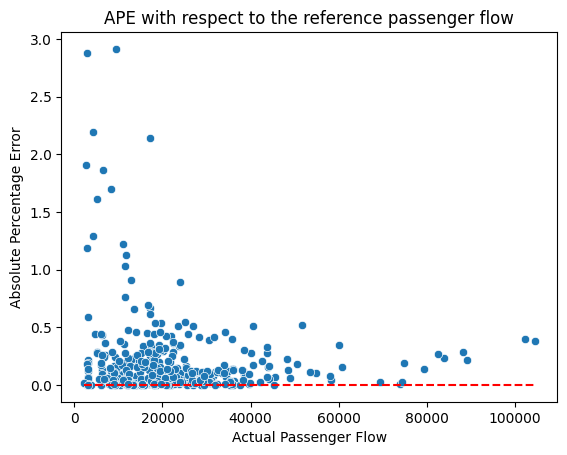

In [ ]:
# test_data = random.choice(test_loader.dataset)
test_data = test_loader.dataset[0]
x, edge_index = test_data.x, test_data.edge_index
output = nodes_gnn_model(x, edge_index)

ape_predictions = MAPE_loss(y_true=test_data.y, y_pred=output.squeeze(), mean=False)
ape_predictions = ape_predictions.detach()

actual_flows = test_data.y.numpy()
predicted_flows = output.detach().squeeze(1).numpy()

print(actual_flows.shape)
print(predicted_flows.shape)

plt.figure(1)
sns.scatterplot(x=actual_flows, y=predicted_flows)
plt.plot([min(actual_flows), max(actual_flows)],
         [min(actual_flows), max(actual_flows)],
         color='red', linestyle='--')  # Perfect match line
plt.xlabel("Actual Passenger Flow")
plt.ylabel("Predicted Passenger Flow")
plt.title("Actual vs Predicted Passenger Flow")

plt.figure(2)
sns.scatterplot(x=actual_flows, y=ape_predictions)
plt.plot([min(actual_flows), max(actual_flows)],
         [0, 0],
         color='red', linestyle='--')  # Perfect match line
plt.xlabel("Actual Passenger Flow")
plt.ylabel("Absolute Percentage Error")
plt.title("APE with respect to the reference passenger flow")

plt.show()


#### Using edges weights (based on node position)

In [14]:
data_dir = "graph_dataset/"

train_degraded_graphs = []
dev_degraded_graphs = []
test_degraded_graphs = []

for i in range(1,11):
    folder_path = os.path.join(data_dir, f'delete_{i}')
    all_files = [file_path for file_path in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file_path))]
    degraded_graphs = []

    print(f"Number of graphs where {i} edges were deleted: {len(all_files)}")
    for file_path in all_files:
        with open(os.path.join(folder_path, file_path), 'rb') as f:
            new_net = pickle.load(f)
        node_idx = torch.tensor([i for i in sorted(new_net.nodes)], dtype=torch.int)
        tensor_edges = torch.tensor([
            [edge[0] for edge in sorted(new_net.edges)],
            [edge[1] for edge in sorted(new_net.edges)]
            ], dtype=torch.long)
        tensor_edges_weight = torch.tensor([
            edge[2]['weight'] for edge in sorted(new_net.edges.data())
            ], dtype=torch.float)
        tensor_traffic = torch.tensor([node['traffic'] for _, node in sorted(new_net.nodes.data())], dtype=torch.float)
        data_graph = Data(x=node_idx, edge_index=tensor_edges, y=tensor_traffic, edge_attr=tensor_edges_weight)
        degraded_graphs.append(data_graph)

    train_split_idx = int(0.9*len(all_files))
    dev_split_idx = int(0.1*train_split_idx)

    dev_degraded_graphs.extend(degraded_graphs[:dev_split_idx])
    train_degraded_graphs.extend(degraded_graphs[dev_split_idx:train_split_idx])
    test_degraded_graphs.extend(degraded_graphs[train_split_idx:])

Number of graphs where 1 edges were deleted: 142
Number of graphs where 2 edges were deleted: 100
Number of graphs where 3 edges were deleted: 100
Number of graphs where 4 edges were deleted: 100
Number of graphs where 5 edges were deleted: 100
Number of graphs where 6 edges were deleted: 100
Number of graphs where 7 edges were deleted: 100
Number of graphs where 8 edges were deleted: 100
Number of graphs where 9 edges were deleted: 100
Number of graphs where 10 edges were deleted: 100


In [15]:
train_loader = DataLoader(train_degraded_graphs, shuffle=True)
dev_loader = DataLoader(dev_degraded_graphs, shuffle=True)
test_loader = DataLoader(test_degraded_graphs, shuffle=True)

In [17]:
input_dim = 100
output_dim = 1

nodes_gnn_model = StationFlowGNN(
    input_dim=input_dim,
    output_dim=output_dim,
    num_nodes=train_loader.dataset[0].x.shape[0],
    use_embeddings=True
)

lr = 0.001
optimizer = optim.Adam(nodes_gnn_model.parameters(), lr=lr)
criterion = torch.nn.L1Loss()

epochs = 20

for epoch in range(epochs):
    nodes_gnn_model.train()
    train_loss = []
    for data in train_loader:
        nodes_gnn_model.train()
        optimizer.zero_grad()
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        output = nodes_gnn_model(x, edge_index, edge_weight)
        loss = criterion(output.squeeze(), data.y)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    dev_loss = []
    nodes_gnn_model.eval()
    for data in dev_loader:
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        output = nodes_gnn_model(x, edge_index,edge_weight)
        loss = MAPE_loss(output.squeeze(), data.y)
        dev_loss.append(loss.item())
    print(f'Epoch {epoch}, Train Loss: {np.mean(train_loss)}, Dev. MAPE: {np.mean(dev_loss)}')


Epoch 0, Train Loss: 8936.182152626074, Dev. MAPE: 0.2727037922989938
Epoch 1, Train Loss: 4813.173279676392, Dev. MAPE: 0.25453145593725224
Epoch 2, Train Loss: 4639.32377848693, Dev. MAPE: 0.2510437899699775
Epoch 3, Train Loss: 4590.899290835123, Dev. MAPE: 0.248558154349686
Epoch 4, Train Loss: 4558.156323762866, Dev. MAPE: 0.24659079874074588
Epoch 5, Train Loss: 4529.792544107301, Dev. MAPE: 0.24493872494466842
Epoch 6, Train Loss: 4503.908000638699, Dev. MAPE: 0.24314406466099522
Epoch 7, Train Loss: 4481.578606049597, Dev. MAPE: 0.2426723914761697
Epoch 8, Train Loss: 4462.296776649511, Dev. MAPE: 0.23928607936187457
Epoch 9, Train Loss: 4443.958225051374, Dev. MAPE: 0.23829386263124405
Epoch 10, Train Loss: 4421.20121613272, Dev. MAPE: 0.23369127608114673
Epoch 11, Train Loss: 4389.763525795597, Dev. MAPE: 0.22979431527276192
Epoch 12, Train Loss: 4348.46533203125, Dev. MAPE: 0.2252582343675757
Epoch 13, Train Loss: 4305.486123903102, Dev. MAPE: 0.22024110231989175
Epoch 14, T

In [18]:
test_mae = []
test_mape = []
nodes_gnn_model.eval()
for data in test_loader:
    x, edge_index = data.x, data.edge_index
    output = nodes_gnn_model(x, edge_index)
    test = set(output.squeeze().tolist())
    print(max(test), min(test))
    MAE = criterion(output.squeeze(), data.y)
    MAPE = MAPE_loss(output.squeeze(), data.y)
    test_mae.append(MAE.item())
    test_mape.append(MAPE.item())
print(f'Test MAE: {np.mean(test_mae)}; Test MAPE: {np.mean(test_mape)}')

137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137698.328125 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137698.328125 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137701.328125 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137698.328125 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
138656.796875 6.5794477462768555
137701.328125 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484375 6.5794477462768555
137706.484

(392,)
(392,)


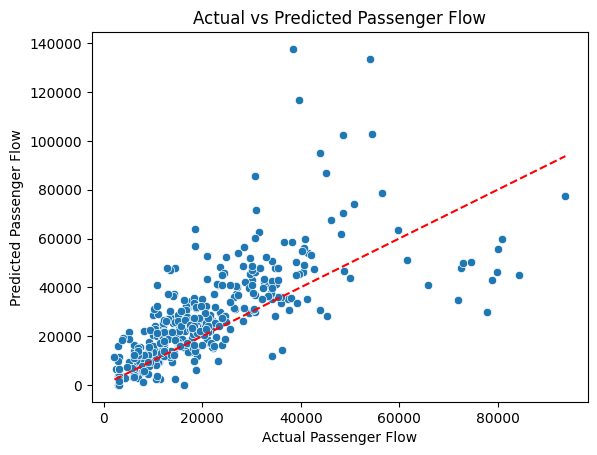

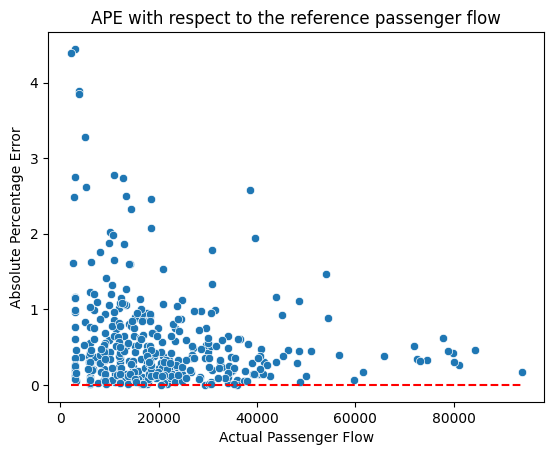

In [19]:
# test_data = random.choice(test_loader.dataset)
test_data = test_loader.dataset[0]
x, edge_index = test_data.x, test_data.edge_index
output = nodes_gnn_model(x, edge_index)

ape_predictions = MAPE_loss(y_true=test_data.y, y_pred=output.squeeze(), mean=False)
ape_predictions = ape_predictions.detach()

actual_flows = test_data.y.numpy()
predicted_flows = output.detach().squeeze(1).numpy()

print(actual_flows.shape)
print(predicted_flows.shape)

plt.figure(1)
sns.scatterplot(x=actual_flows, y=predicted_flows)
plt.plot([min(actual_flows), max(actual_flows)],
         [min(actual_flows), max(actual_flows)],
         color='red', linestyle='--')  # Perfect match line
plt.xlabel("Actual Passenger Flow")
plt.ylabel("Predicted Passenger Flow")
plt.title("Actual vs Predicted Passenger Flow")

plt.figure(2)
sns.scatterplot(x=actual_flows, y=ape_predictions)
plt.plot([min(actual_flows), max(actual_flows)],
         [0, 0],
         color='red', linestyle='--')  # Perfect match line
plt.xlabel("Actual Passenger Flow")
plt.ylabel("Absolute Percentage Error")
plt.title("APE with respect to the reference passenger flow")

plt.show()


### Using Node2Vec embeddings as input

In [ ]:
from torch_geometric.nn import Node2Vec

In [ ]:
node_idx = torch.tensor([i for i in sorted(new_net.nodes)], dtype=torch.int)
tensor_edges = torch.tensor([
    [edge[0] for edge in sorted(new_net.edges)],
    [edge[1] for edge in sorted(new_net.edges)]
    ], dtype=torch.long)
init_data_graph = Data(x=node_idx, edge_index=tensor_edges)

In [ ]:

model = Node2Vec(
    data.edge_index,
    embedding_dim=100,
    walks_per_node=10,
    walk_length=20,
    context_size=10,
    p=1.0,
    q=1.0,
    num_negative_samples=1,
)